In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import random
import tensorflow.keras.utils as utils
import pydot
from tensorflow.keras import regularizers

In [15]:
import random
def create_rand_list(max_val, count):
    randomlist = random.sample(range(0, max_val + 1), count)
    return randomlist

In [16]:
dataset_dir = "Datasets/houseprices_ready.csv"

In [41]:
df = pd.read_csv(dataset_dir, index_col=0)
df = df.fillna(df.mean())
df.head(10)

,AboveMedianPrice,LotArea,OverallQual,OverallCond,TotalBsmtSF,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea
0,1,8450,7,5,856,2,1,3,8,0,548
1,1,9600,6,8,1262,2,0,3,6,1,460
2,1,11250,7,5,920,2,1,3,6,1,608
3,0,9550,7,5,756,1,0,3,7,1,642
4,1,14260,8,5,1145,2,1,4,9,1,836
5,0,14115,5,5,796,1,1,1,5,0,480
6,1,10084,8,5,1686,2,0,3,7,1,636
7,1,10382,7,6,1107,2,1,3,7,2,484
8,0,6120,7,5,952,2,0,2,8,2,468
9,0,7420,5,6,991,1,0,2,5,2,205


In [43]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(df.iloc[:700,1:])
dfs_features_pca_5 = pd.DataFrame(data = principalComponents) 
dfs_features_pca_5

,0,1,2,3
0,-2416.107443,-162.204118,-139.073096,1.710998
1,-1262.874388,191.710215,60.619841,-0.449917
2,384.473777,-108.739327,-178.842815,-0.165891
3,-1316.786776,-241.129946,-257.817263,0.494238
4,3396.829379,144.997001,-333.907382,2.138869
...,...,...,...,...
695,2946.885966,36.272918,-69.988887,-1.844490
696,-4868.887629,-468.032626,121.884872,-1.649148
697,-4445.532191,-93.527930,126.632270,-0.625268
698,-2416.285113,-186.098263,74.988536,-1.010632


In [18]:
df.isnull().values.any()

False

In [19]:
def transform_dataset(df, group_num):
    df = df.sample(frac=1, random_state=41)
    col_num = len(df.columns)
    row_num = len(df.index)
    dfs = [None]*group_num
    dfs_features = [None]*group_num
    dfs_scaleds = [None]*group_num
    dfs_new = [None]*group_num
    scaler = StandardScaler()
    for i in range(group_num):
        dfs[i] = df.iloc[int(i/group_num*row_num):int((i+1)/group_num*row_num), :]
        dfs_features[i] = dfs[i].iloc[:,1:]
        dfs_features[i] = dfs_features[i].sample(frac=1, axis=1)
        df_features_scaled_temp = pd.DataFrame(scaler.fit_transform(dfs_features[i]), columns = dfs_features[i].columns, index = dfs_features[i].index)
        dfs_new[i] = pd.concat([dfs[i].iloc[:,0], df_features_scaled_temp], axis=1)
        dfs_new[i]['group'] = i
        cols_num = len(dfs_new[i].columns)
        col_names = [j for j in range(cols_num)]
        dfs_new[i].columns = col_names
    df_final = pd.concat(dfs_new, axis=0)
    last_col_num = cols_num - 1
    df_new = df_final.rename(columns={last_col_num: 'group'})
    df_final_onehot = pd.concat([df_new.iloc[:,:-1], pd.get_dummies(df_new.group, prefix='group')], axis=1)
    df_final_onehot = df_final_onehot.sample(frac=1)
    return df_final_onehot

#Check actiavation whether sigmoid or relu!
def get_MICS_model(inp_size, drop_out, hidden_num = 4, hidden_size=32):
    inputs = keras.layers.Input(shape=(inp_size), name="input")
        
    h = keras.layers.Dense(hidden_size, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3))(inputs)
    h = keras.layers.Dropout(drop_out)(h)
    for hidden in range(hidden_num):
        h = keras.layers.Dense(hidden_size, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3))(h)
        h = keras.layers.Dropout(drop_out)(h) 

    outputs = keras.layers.Dense(1, activation="relu")(h)    
    return keras.Model(inputs=[inputs], outputs = outputs)

    
    

In [62]:
from sklearn.decomposition import PCA
def transform_dataset_pca(df, group_num, pca_num):
    df = df.sample(frac=1, random_state=41)
    col_num = len(df.columns)
    row_num = len(df.index)
    dfs = [None]*group_num
    dfs_features = [None]*group_num
    dfs_scaleds = [None]*group_num
    dfs_new = [None]*group_num
    scaler = StandardScaler()
    for i in range(group_num):
        dfs[i] = df.iloc[int(i/group_num*row_num):int((i+1)/group_num*row_num), :]
        dfs_features[i] = dfs[i].iloc[:,1:]
        dfs_features[i] = dfs_features[i].sample(frac=1, axis=1)
        
        pca = PCA(n_components=pca_num)
        principalComponents = pca.fit_transform(dfs_features[i])
        dfs_features[i] = pd.DataFrame(data = principalComponents, index=dfs_features[i].index)        
        
        df_features_scaled_temp = pd.DataFrame(scaler.fit_transform(dfs_features[i]), columns = dfs_features[i].columns, index = dfs_features[i].index)
        dfs_new[i] = pd.concat([dfs[i].iloc[:,0], df_features_scaled_temp], axis=1)
        dfs_new[i]['group'] = i
        cols_num = len(dfs_new[i].columns)
        col_names = [j for j in range(cols_num)]
        dfs_new[i].columns = col_names
    df_final = pd.concat(dfs_new, axis=0)
    last_col_num = cols_num - 1
    df_new = df_final.rename(columns={last_col_num: 'group'})
    df_final_onehot = pd.concat([df_new.iloc[:,:-1], pd.get_dummies(df_new.group, prefix='group')], axis=1)
    df_final_onehot = df_final_onehot.sample(frac=1)
    return df_final_onehot

In [ ]:
loss_dict = {1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[], 13:[], 14:[], 15:[]}
for group_number in range(1,16):
    for m in range(5):       
        df_final_onehot = transform_dataset(df, 1)
        
        thr1 = 0.65/group_number
        thr2 = 5/4*thr1
        ratios = [thr1, thr2]

        col_num_final = len(df_final_onehot.columns)
        row_num_final = len(df_final_onehot.index)

        trainx = df_final_onehot.iloc[:int(ratios[0]*row_num_final), 1:(col_num_final)]
        trainy = df_final_onehot.iloc[:int(ratios[0]*row_num_final), 0]

        valx = df_final_onehot.iloc[int(ratios[0]*row_num_final):int(ratios[1]*row_num_final), 1:(col_num_final)]
        valy = df_final_onehot.iloc[int(ratios[0]*row_num_final):int(ratios[1]*row_num_final), 0]

        testx = df_final_onehot.iloc[int(ratios[1]*row_num_final):, 1:(col_num_final)]
        testy = df_final_onehot.iloc[int(ratios[1]*row_num_final):, 0]

        inp_size = len(trainx.columns)
        MICS_model = get_MICS_model(inp_size, drop_out = 0.25)
        checkpoint_filepath = 'tmp/checkpoint'
        callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50), 
                keras.callbacks.ReduceLROnPlateau("val_loss", factor = 0.8, patience=30,
                                                 verbose = 2, mode = "auto", 
                                                  min_lr = 1e-6),
                keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='val_loss',
                mode='min',
                save_best_only=True)]


        MICS_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=keras.losses.MeanSquaredError())
        history = MICS_model.fit(x = [trainx], y = trainy.values,  
                                 validation_data = ([valx], valy.values),
                                 epochs=300, batch_size = 300, callbacks=callback)
        training_val_accuracy = history.history["val_loss"]
        #best_row_index = np.argmax(training_val_accuracy)
        #best_val_accuracy = training_val_accuracy[best_row_index]
        #best_val_accuracy
        MICS_model.load_weights(checkpoint_filepath)
        result = MICS_model.evaluate(x = [testx], y = testy.values)
        loss_dict[group_number].append(np.sqrt(result))

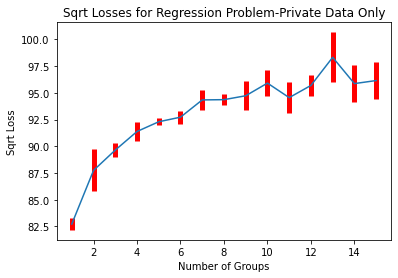

In [255]:
plt.errorbar(x=loss_dict.keys(), y = [statistics.mean(loss_list) for loss_list in loss_dict.values()], 
             yerr=[statistics.stdev(loss_list) for loss_list in loss_dict.values()],  ecolor="r",
             elinewidth=5)
plt.title("Sqrt Losses for Regression Problem-Private Data Only")
plt.xlabel("Number of Groups")
plt.ylabel("Sqrt Loss")
plt.savefig('SqrtLosses_PrivateData.png')

In [247]:
np.sqrt(results)

87.92763803975403

In [ ]:
accuracy_dicts = [{1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[], 13:[], 14:[], 15:[]}]*5
for group_number in range(1,16):
    for m in range(5):

        df_final_onehot = transform_dataset(df, group_number)

        ratios = [0.65, 0.8]

        col_num_final = len(df_final_onehot.columns)
        row_num_final = len(df_final_onehot.index)

        trainx = df_final_onehot.iloc[:int(ratios[0]*row_num_final), 1:(col_num_final)]
        trainy = df_final_onehot.iloc[:int(ratios[0]*row_num_final), 0]

        valx = df_final_onehot.iloc[int(ratios[0]*row_num_final):int(ratios[1]*row_num_final), 1:(col_num_final)]
        valy = df_final_onehot.iloc[int(ratios[0]*row_num_final):int(ratios[1]*row_num_final), 0]

        testx = df_final_onehot.iloc[int(ratios[1]*row_num_final):, 1:(col_num_final)]
        testy = df_final_onehot.iloc[int(ratios[1]*row_num_final):, 0]

        inp_size = len(trainx.columns)
        MICS_model = get_MICS_model(inp_size, drop_out = 0.25)
        checkpoint_filepath = 'tmp/checkpoint'
        callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50), 
                keras.callbacks.ReduceLROnPlateau("val_loss", factor = 0.8, patience=30,
                                                 verbose = 2, mode = "auto", 
                                                  min_lr = 1e-6),
                keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='val_accuracy',
                mode='max',
                save_best_only=True)]


        MICS_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
        history = MICS_model.fit(x = [trainx], y = trainy.values,  
                                 validation_data = ([valx], valy.values),
                                 epochs=300, batch_size = 32, callbacks=callback)
        training_val_accuracy = history.history["val_accuracy"]
        #best_row_index = np.argmax(training_val_accuracy)
        #best_val_accuracy = training_val_accuracy[best_row_index]
        #best_val_accuracy
        MICS_model.load_weights(checkpoint_filepath)
        results = MICS_model.evaluate(x = [testx], y = testy.values)
        accuracy_dict[group_number].append(results[1])

In [217]:
import statistics

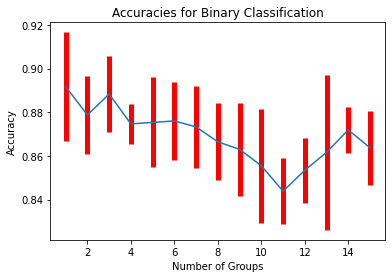

In [228]:
plt.errorbar(x=accuracy_dict.keys(), y = [statistics.mean(acc_list) for acc_list in accuracy_dict.values()], 
             yerr=[statistics.stdev(acc_list) for acc_list in accuracy_dict.values()],  ecolor="r",
             elinewidth=5)
plt.title("Accuracies for Binary Classification")
plt.xlabel("Number of Groups")
plt.ylabel("Accuracy")
plt.savefig('Binary_Accuracies.png')


In [ ]:
accuracy_dicts = [{1:[], 2:[], 3:[], 4:[], 5:[], 6:[]} for i in range(5)]
pca_vals = [2,4,6,8,10]
for group_number in range(1,7):
    for m in range(5):
        for pca_index in range(5):
            
            df_final_onehot = transform_dataset_pca(df, group_number, pca_vals[pca_index])

            thr_1 = 0.65
            thr_2 = 0.8

            ratios = [thr_1, thr_2]

            col_num_final = len(df_final_onehot.columns)
            row_num_final = len(df_final_onehot.index)

            trainx = df_final_onehot.iloc[:int(ratios[0]*row_num_final), 1:(col_num_final)]
            trainy = df_final_onehot.iloc[:int(ratios[0]*row_num_final), 0]

            valx = df_final_onehot.iloc[int(ratios[0]*row_num_final):int(ratios[1]*row_num_final), 1:(col_num_final)]
            valy = df_final_onehot.iloc[int(ratios[0]*row_num_final):int(ratios[1]*row_num_final), 0]

            testx = df_final_onehot.iloc[int(ratios[1]*row_num_final):, 1:(col_num_final)]
            testy = df_final_onehot.iloc[int(ratios[1]*row_num_final):, 0]

            inp_size = len(trainx.columns)
            MICS_model = get_MICS_model(inp_size, drop_out = 0.25)
            checkpoint_filepath = 'tmp/checkpoint'
            callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50), 
                    keras.callbacks.ReduceLROnPlateau("val_loss", factor = 0.8, patience=30,
                                                     verbose = 2, mode = "auto", 
                                                      min_lr = 1e-6),
                    keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                    save_weights_only=True,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True)]


            MICS_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
            history = MICS_model.fit(x = [trainx], y = trainy.values,  
                                     validation_data = ([valx], valy.values),
                                     epochs=300, batch_size = 32, callbacks=callback)
            training_val_accuracy = history.history["val_accuracy"]
            #best_row_index = np.argmax(training_val_accuracy)
            #best_val_accuracy = training_val_accuracy[best_row_index]
            #best_val_accuracy
            MICS_model.load_weights(checkpoint_filepath)
            results = MICS_model.evaluate(x = [testx], y = testy.values)
            accuracy_dicts[pca_index][group_number].append(results[1])

Epoch 1/300
30/30 [==============================] - 0s 6ms/step - loss: 1.0356 - accuracy: 0.5616 - val_loss: 0.7164 - val_accuracy: 0.6712
Epoch 2/300
30/30 [==============================] - 0s 2ms/step - loss: 0.8964 - accuracy: 0.6913 - val_loss: 0.7357 - val_accuracy: 0.7489
Epoch 3/300
30/30 [==============================] - 0s 1ms/step - loss: 0.8842 - accuracy: 0.6807 - val_loss: 0.7175 - val_accuracy: 0.6621
Epoch 4/300
30/30 [==============================] - 0s 1ms/step - loss: 0.8293 - accuracy: 0.6565 - val_loss: 0.6622 - val_accuracy: 0.6804
Epoch 5/300
30/30 [==============================] - 0s 1ms/step - loss: 0.7489 - accuracy: 0.6839 - val_loss: 0.6593 - val_accuracy: 0.7397
Epoch 6/300
30/30 [==============================] - 0s 1ms/step - loss: 0.8686 - accuracy: 0.7144 - val_loss: 0.8539 - val_accuracy: 0.7123
Epoch 7/300
30/30 [==============================] - 0s 2ms/step - loss: 1.0138 - accuracy: 0.7187 - val_loss: 0.8395 - val_accuracy: 0.7443
Epoch 8/300
3

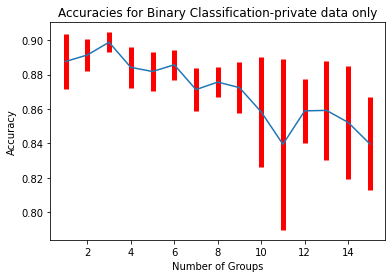

In [233]:
plt.errorbar(x=accuracy_dict.keys(), y = [statistics.mean(acc_list) for acc_list in accuracy_dict.values()], 
             yerr=[statistics.stdev(acc_list) for acc_list in accuracy_dict.values()],  ecolor="r",
             elinewidth=5)
plt.title("Accuracies for Binary Classification-private data only")
plt.xlabel("Number of Groups")
plt.ylabel("Accuracy")
plt.savefig('Binary_Accuracies_less_data.png')


In [3]:
accuracy_dictzz = [{1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[], 13:[], 14:[], 15:[]} for i in range(5)]
accuracy_dictzz[1][3]="a"
accuracy_dictzz

[{1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: [],
  13: [],
  14: [],
  15: []},
 {1: [],
  2: [],
  3: 'a',
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: [],
  13: [],
  14: [],
  15: []},
 {1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: [],
  13: [],
  14: [],
  15: []},
 {1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: [],
  13: [],
  14: [],
  15: []},
 {1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: [],
  13: [],
  14: [],
  15: []}]